1. Train model

[INFO] compiling model...
[INFO] training network...
Epoch 1/15
165/165 [==============================] - 12s 65ms/step - loss: 0.7174 - accuracy: 0.7309 - val_loss: 0.3064 - val_accuracy: 0.8682
Epoch 2/15
165/165 [==============================] - 11s 64ms/step - loss: 0.4838 - accuracy: 0.8605 - val_loss: 0.3014 - val_accuracy: 0.8724
Epoch 3/15
165/165 [==============================] - 11s 64ms/step - loss: 0.4266 - accuracy: 0.8787 - val_loss: 0.3030 - val_accuracy: 0.8777
Epoch 4/15
165/165 [==============================] - 11s 64ms/step - loss: 0.3983 - accuracy: 0.8912 - val_loss: 0.2619 - val_accuracy: 0.8952
Epoch 5/15
165/165 [==============================] - 11s 65ms/step - loss: 0.3741 - accuracy: 0.8991 - val_loss: 0.2639 - val_accuracy: 0.8975
Epoch 6/15
165/165 [==============================] - 11s 65ms/step - loss: 0.3559 - accuracy: 0.9052 - val_loss: 0.3244 - val_accuracy: 0.8648
Epoch 7/15
165/165 [==============================] - 11s 64ms/step - loss: 0.3354 

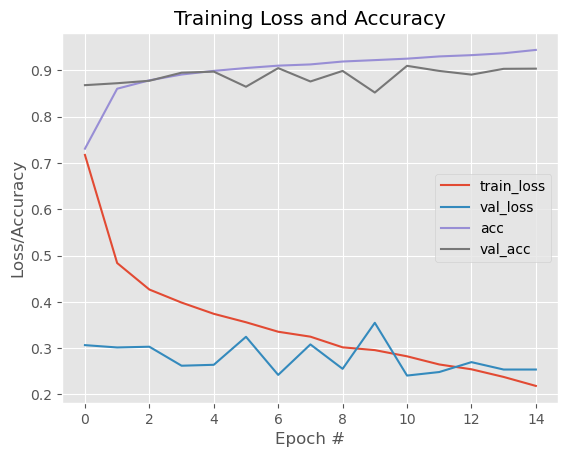

In [2]:
import imutils
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from pyimagesearch.nn.conv.lenet import LeNet
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

dataset = "./dataset"
model_path = "./lenet.hdf5"

data = []
labels = []

for imagePath in sorted(list(paths.list_images(dataset))):
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = imutils.resize(image, width=28)
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-3]
	label = "smiling" if label == "positives" else "not_smiling"
	labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)

# calculate the total number of training images in each class and
# initialize a dictionary to store the class weights
classTotals = labels.sum(axis=0)
classWeight = dict()

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	class_weight=classWeight, batch_size=64, epochs=15, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

# save the model to disk
print("[INFO] serializing network...")
model.save(model_path)

# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()



2. Test model

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2


cascade = "./haarcascade_frontalface_default.xml"
model_path ="./lenet.hdf5"
video = "./video/portrait-of-a-happy-smiling-woman.mp4"

detector = cv2.CascadeClassifier(cascade)
model = load_model(model_path)

camera = cv2.VideoCapture(video)

while True:
	(grabbed, frame) = camera.read()

	if not grabbed:
		break

	# resize the frame, convert it to grayscale, and then clone the
	# original frame so we can draw on it later in the program
	frame = imutils.resize(frame, width=300)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	frameClone = frame.copy()

	# detect faces in the input frame, then clone the frame so that
	# we can draw on it
	rects = detector.detectMultiScale(gray, scaleFactor=1.1, 
		minNeighbors=5, minSize=(30, 30),
		flags=cv2.CASCADE_SCALE_IMAGE)
	
	# loop over the face bounding boxes
	for (fX, fY, fW, fH) in rects:
		# extract the ROI of the face from the grayscale image,
		# resize it to a fixed 28x28 pixels, and then prepare the
		# ROI for classification via the CNN
		roi = gray[fY:fY + fH, fX:fX + fW]
		roi = cv2.resize(roi, (28, 28))
		roi = roi.astype("float") / 255.0
		roi = img_to_array(roi)
		roi = np.expand_dims(roi, axis=0)

		# determine the probabilities of both "smiling" and "not
		# smiling", then set the label accordingly
		(notSmiling, smiling) = model.predict(roi)[0]
		label = "Smiling" if smiling > notSmiling else "Not Smiling"

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frameClone, label, (fX, fY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
		cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
			(0, 0, 255), 2)

	# show our detected faces along with smiling/not smiling labels
	plt.axis("off")
	plt.imshow(cv2.cvtColor(frameClone, cv2.COLOR_BGR2RGB))
	plt.show()

camera.release()



